<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/08_pytorch_paper_replicating_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f46a93c7fd0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

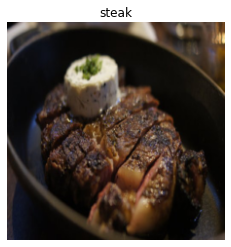

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
NUM_TRANSFORMER_LAYERS = 12
EMBEDDING_DIM = 768
NUM_HEADS = 12
MLP_SIZE = 3072
MLP_DROPOUT = 0.1

# create inbuilt transformer encoder layer
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM,
                                                       nhead=NUM_HEADS,
                                                       dim_feedforward=MLP_SIZE,
                                                       dropout=MLP_DROPOUT,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True)

# create inbuilt transformer encoder using stacked transformer encoder layers
transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, NUM_TRANSFORMER_LAYERS)

# display architecture and layers of transformer encoder
summary(transformer_encoder, input_size=(1, 197, EMBEDDING_DIM), col_names=['input_size', 'output_size', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]        [1, 197, 768]        True
├─ModuleList (layers)                    --                   --                   True
│    └─TransformerEncoderLayer (0)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (1)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (2)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (3)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (4)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (5)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (6)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLayer (7)       [1, 197, 768]        [1, 197, 768]        True
│    └─TransformerEncoderLa

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [11]:
%%writefile vit.py
import torch
from torch import nn

# custom ViT model
class ViT(nn.Module):
  def __init__(self, img_size=224,
               patch_size=16,
               num_channels=3,
               num_transformer_layers=12,
               embedding_dim=768,
               num_heads=12,
               attn_dropout=0,
               mlp_size=3072,
               embedding_dropout=0.1,
               mlp_dropout=0.1,
               num_classes=1000):
    
    # instantiate base class
    super(ViT, self).__init__()
    # ensure that patches cover the entire image input
    assert(img_size % patch_size == 0)
    # calculate the number of patches within the image input, N = WH / p^2
    self.num_patches = (img_size * img_size) // patch_size**2

    # class embedding
    self.class_embedding = nn.Parameter(torch.ones(1, 1, embedding_dim))
    # position embedding
    self.position_embedding = nn.Parameter(torch.ones(1, self.num_patches+1, embedding_dim))
    # embedding dropout layer
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    # patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=num_channels, embedding_size=embedding_dim, patch_size=patch_size)
    # transformer encoder using stacked transformer encoder blocks
    self.transform_encoder = nn.Sequential(
        *[TransformEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
    )
    # classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    # get batch size of input
    batch_size = x.shape[0]
    # create patch embedding from input images
    patch_embedding = self.patch_embedding(x)
    # expand class embedding token to cover the entire batch
    class_embedding_token = self.class_embedding.expand(batch_size, -1, -1)
    # prepend class embedding token to patch embedding
    x = torch.concat((class_embedding_token, patch_embedding), dim=1)
    # add the position embedding vector
    x = x + self.position_embedding
    # pass patch and position embedding through embedding dropout layer
    x = self.embedding_dropout(x)
    # pass patch and position embedding through complete transformer encoder
    x = self.transform_encoder(x)
    # pass the first logit (index 0) for every sample in the batch to the classifier
    x = self.classifier(x[:, 0]) # embedding of the first patch for every sample in the batch [batch_size, embedding_dim]

    return x


# create custom patch embedding layer
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embedding_size=768, patch_size=16):
    super(PatchEmbedding, self).__init__()
    self.in_channels = in_channels
    self.embedding_size = embedding_size
    self.patch_size = patch_size
    self.embedding = nn.Sequential(
        nn.Conv2d(in_channels=self.in_channels, out_channels=self.embedding_size, kernel_size=self.patch_size, stride=self.patch_size, padding=0),
        # flatten patches
        nn.Flatten(start_dim=2, end_dim=3)
    )

  def forward(self, x):
    # check dimension of input can be divided completly by patches
    assert(x.shape[-1] % self.patch_size == 0)
    output = self.embedding(x)
    # swap embedding and patch dimensions
    return output.permute(0, 2, 1)


# custom multi-head self attention layer
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
    super(MultiHeadSelfAttentionBlock, self).__init__()
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.attn_dropout = attn_dropout
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=self.embedding_dim,
                                     num_heads=self.num_heads,
                                     dropout=self.attn_dropout,
                                     batch_first=True)
    
  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    output, _ = self.multihead_attn(query=x, # query embedding
                         key = x, # key embedding
                         value = x, # value embedding
                         need_weights=False)
    return output


# custom MLP layer
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim=768, hidden_dim=3072, dropout=0.1):
    super(MLPBlock, self).__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=hidden_dim),
        # Gaussian Error Linear Units
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_dim, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    # MLP block
    output = self.mlp(x)
    return output


# custom transformer encoder block
class TransformEncoderBlock(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0, mlp_size=3072, mlp_dropout=0.1):
    super(TransformEncoderBlock, self).__init__()
    self.msa = MultiHeadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)
    self.mlp = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

  def forward(self, x):
    x = self.msa(x) + x
    x = self.mlp(x) + x
    return x



Overwriting vit.py


In [12]:
from vit import ViT

# instantiate custom ViT model
custom_vision_transformer = ViT(num_classes=len(class_names)) # modifiy the number of classes for our problem
# display summary of ViT model
summary(custom_vision_transformer,
        input_size=(1, 3, 224, 224), # [batch, image_channels, image_width, image_height]
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        True
│    └─Sequential (embedding)                                [1, 3, 224, 224]     [1, 768, 196]        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     True
│    │    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --
├─Sequential (transform_encoder)                             [1, 197, 768]        [1, 197, 768]        True
│    └─TransformEncoderBlock (0)                             [1, 197, 768]        [1, 197, 768]        True
│    │    └─MultiHeadSelfAt

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [13]:
# download 20 percent pizza steak sushi dataset
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


#### Pretrained Vit-16 Model

In [14]:
from torchvision import models

# create pretrained ViT model
vit_weights = models.ViT_B_16_Weights.DEFAULT # store best available weights for ViT-16
# create a ViT model initialized with the best available pretrained weights
pretrained_vit = models.vit_b_16(weights=vit_weights).to(device)

In [15]:
# display summary of pretrained ViT model
summary(pretrained_vit, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 1000]            True
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     True
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        True
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        True
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        True
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]        [1, 197, 768]        True
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]        [1, 197, 768]        True
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]        [1, 197, 768]        True
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]        

In [16]:
# freeze training parameters
for param in pretrained_vit.parameters():
  param.requires_grad = False

# modify the number of output classes
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [17]:
# display summary of pretrained ViT model
summary(pretrained_vit, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'trainable'], col_width=20) # trainable parameters should now be frozen

Layer (type:depth-idx)                        Input Shape          Output Shape         Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 3]               Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     False
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        False
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock: 3-5                 [1, 197, 76

In [18]:
# store the original transforms used by the pretrained ViT model
vit_transforms = vit_weights.transforms() 
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [19]:
# create dataloaders using pretrained ViT transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=vit_transforms,
                                                                               batch_size=32)

In [20]:
# train and evaluate pretrained ViT
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_default_results = engine.train(model=pretrained_vit,
                                              train_dataloader=train_dataloader,
                                              test_dataloader=test_dataloader,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=10,
                                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5344 | train_acc: 0.8375 | test_loss: 0.0863 | test_acc: 0.9812
Epoch: 2 | train_loss: 0.1350 | train_acc: 0.9646 | test_loss: 0.0834 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.0836 | train_acc: 0.9792 | test_loss: 0.0622 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.0505 | train_acc: 0.9833 | test_loss: 0.0567 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0390 | train_acc: 0.9896 | test_loss: 0.0555 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0407 | train_acc: 1.0000 | test_loss: 0.0538 | test_acc: 0.9659
Epoch: 7 | train_loss: 0.0299 | train_acc: 0.9979 | test_loss: 0.0589 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0220 | train_acc: 1.0000 | test_loss: 0.0583 | test_acc: 0.9659
Epoch: 9 | train_loss: 0.0299 | train_acc: 1.0000 | test_loss: 0.0539 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0162 | train_acc: 1.0000 | test_loss: 0.0517 | test_acc: 0.9875


Pretrained EfficientNet B2

In [21]:
from torchvision import models

# store the best available weights of the pretrained EffNetB2 model
effnetb2_weights = models.EfficientNet_B2_Weights.DEFAULT
# create effnet model using pretrained weights
pretrained_effnetb2 = models.efficientnet_b2(weights=effnetb2_weights).to(device)

In [22]:
# display summary of pretrained efficient net b2
summary(pretrained_effnetb2, input_size=(1, 3, 288, 288), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Trainable
EfficientNet                                            [1, 3, 288, 288]     [1, 1000]            True
├─Sequential: 1-1                                       [1, 3, 288, 288]     [1, 1408, 9, 9]      True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 288, 288]     [1, 32, 144, 144]    True
│    │    └─Conv2d: 3-1                                 [1, 3, 288, 288]     [1, 32, 144, 144]    True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 144, 144]    [1, 32, 144, 144]    True
│    │    └─SiLU: 3-3                                   [1, 32, 144, 144]    [1, 32, 144, 144]    --
│    └─Sequential: 2-2                                  [1, 32, 144, 144]    [1, 16, 144, 144]    True
│    │    └─MBConv: 3-4                                 [1, 32, 144, 144]    [1, 16, 144, 144]    True
│    │    └─MBConv: 3-5                                 [1, 16, 144, 1

In [23]:
# freeze training parameters
for param in pretrained_effnetb2.features.parameters():
  param.requires_grad = False

# modify the classifier layer and number of output classes
set_seeds()
pretrained_effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1408, out_features=len(class_names))
).to(device)

In [24]:
# display summary of pretrained efficient net b2
summary(pretrained_effnetb2, input_size=(1, 3, 288, 288), col_names=['input_size', 'output_size', 'trainable'], col_width=20) # trainable parameters are now frozen

Layer (type:depth-idx)                                  Input Shape          Output Shape         Trainable
EfficientNet                                            [1, 3, 288, 288]     [1, 3]               Partial
├─Sequential: 1-1                                       [1, 3, 288, 288]     [1, 1408, 9, 9]      False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 288, 288]     [1, 32, 144, 144]    False
│    │    └─Conv2d: 3-1                                 [1, 3, 288, 288]     [1, 32, 144, 144]    False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 144, 144]    [1, 32, 144, 144]    False
│    │    └─SiLU: 3-3                                   [1, 32, 144, 144]    [1, 32, 144, 144]    --
│    └─Sequential: 2-2                                  [1, 32, 144, 144]    [1, 16, 144, 144]    False
│    │    └─MBConv: 3-4                                 [1, 32, 144, 144]    [1, 16, 144, 144]    False
│    │    └─MBConv: 3-5                                 [1, 1

In [25]:
# store the original transforms used by the pretrained efficient net b2
effnetb2_transforms = effnetb2_weights.transforms()
print(effnetb2_transforms)

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [26]:
# create dataloaders using automatic transform used by pretrained efficient net b2
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=effnetb2_transforms,
                                                                               batch_size=32)

In [27]:
# train and evaluae pretrained efficient net b2
optimizer = torch.optim.Adam(params=pretrained_effnetb2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_effnetb2_default_results = engine.train(model=pretrained_effnetb2,
                                                   train_dataloader=train_dataloader,
                                                   test_dataloader=test_dataloader,
                                                   optimizer=optimizer,
                                                   loss_fn=loss_fn,
                                                   epochs=10,
                                                   device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9729 | train_acc: 0.5583 | test_loss: 0.7356 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7212 | train_acc: 0.8500 | test_loss: 0.5849 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5807 | train_acc: 0.8583 | test_loss: 0.4883 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4471 | train_acc: 0.9021 | test_loss: 0.4308 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4332 | train_acc: 0.8896 | test_loss: 0.3878 | test_acc: 0.9506
Epoch: 6 | train_loss: 0.4155 | train_acc: 0.8896 | test_loss: 0.3488 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4237 | train_acc: 0.8708 | test_loss: 0.3240 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3841 | train_acc: 0.8917 | test_loss: 0.3374 | test_acc: 0.9506
Epoch: 9 | train_loss: 0.3697 | train_acc: 0.8958 | test_loss: 0.3081 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3535 | train_acc: 0.8604 | test_loss: 0.2797 | test_acc: 0.9625


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [28]:
from torchvision import models

# store the SWAG weights of the pretrained ViT model
vit_weights_swag = models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
# create pretrained ViT model using SWAG weights
pretrained_vit_swag = models.vit_b_16(weights=vit_weights_swag).to(device)

In [29]:
# display summary of pretrained ViT model
summary(pretrained_vit_swag, input_size=(1, 3, 384, 384), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Trainable
VisionTransformer                             [1, 3, 384, 384]     [1, 1000]            True
├─Conv2d: 1-1                                 [1, 3, 384, 384]     [1, 768, 24, 24]     True
├─Encoder: 1-2                                [1, 577, 768]        [1, 577, 768]        True
│    └─Dropout: 2-1                           [1, 577, 768]        [1, 577, 768]        --
│    └─Sequential: 2-2                        [1, 577, 768]        [1, 577, 768]        True
│    │    └─EncoderBlock: 3-1                 [1, 577, 768]        [1, 577, 768]        True
│    │    └─EncoderBlock: 3-2                 [1, 577, 768]        [1, 577, 768]        True
│    │    └─EncoderBlock: 3-3                 [1, 577, 768]        [1, 577, 768]        True
│    │    └─EncoderBlock: 3-4                 [1, 577, 768]        [1, 577, 768]        True
│    │    └─EncoderBlock: 3-5                 [1, 577, 768]        

In [30]:
# freeze training parameters
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# modify the classifier output of pretrained Vit model
set_seeds()
pretrained_vit_swag.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [31]:
# display summary of pretrained ViT
summary(pretrained_vit_swag, input_size=(1, 3, 384, 384), col_names=['input_size', 'output_size', 'trainable'], col_width=20) # trainable parameters are now frozen

Layer (type:depth-idx)                        Input Shape          Output Shape         Trainable
VisionTransformer                             [1, 3, 384, 384]     [1, 3]               Partial
├─Conv2d: 1-1                                 [1, 3, 384, 384]     [1, 768, 24, 24]     False
├─Encoder: 1-2                                [1, 577, 768]        [1, 577, 768]        False
│    └─Dropout: 2-1                           [1, 577, 768]        [1, 577, 768]        --
│    └─Sequential: 2-2                        [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock: 3-1                 [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock: 3-2                 [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock: 3-3                 [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock: 3-4                 [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock: 3-5                 [1, 577, 76

In [32]:
# store original transformed used by pretrained ViT model
vit_transforms_swag = vit_weights_swag.transforms()
print(vit_transforms_swag)

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [33]:
# create dataloaders using automatic transform of pretrained ViT model
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=vit_transforms_swag,
                                                                               batch_size=32)

In [34]:
# train and evaluate pretrained ViT model
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                           train_dataloader=train_dataloader,
                                           test_dataloader = test_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           epochs=10,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4488 | train_acc: 0.9167 | test_loss: 0.0024 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0359 | train_acc: 0.9896 | test_loss: 0.0109 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0141 | train_acc: 0.9958 | test_loss: 0.0013 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0040 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0027 | train_acc: 1.0000 | test_loss: 0.0007 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0016 | train_acc: 1.0000 | test_loss: 0.0007 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0017 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0009 | train_acc: 1.0000 | test_loss: 0.0010 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000


### Plot ViT-16 Default Results

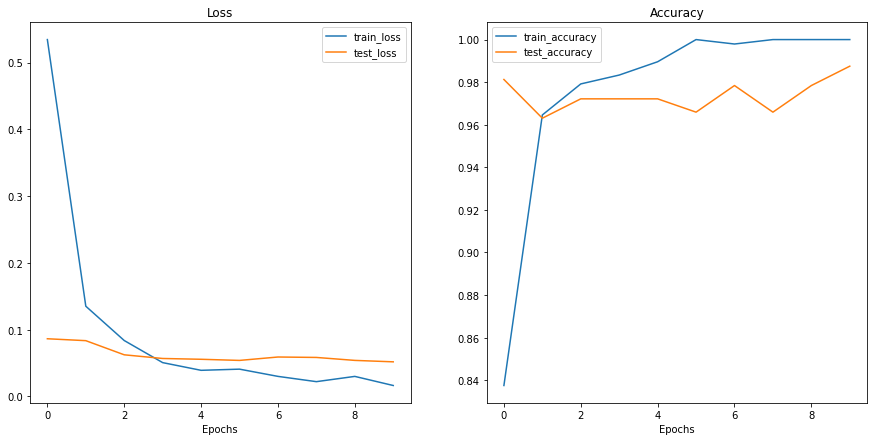

In [35]:
plot_loss_curves(pretrained_vit_default_results)

### Plot EfficientNet B2 Default Results

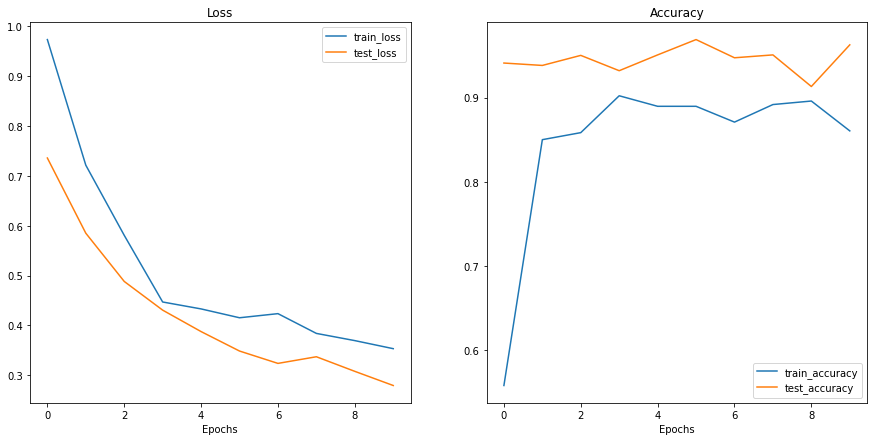

In [36]:
plot_loss_curves(pretrained_effnetb2_default_results)

### Plot ViT-16 SWAG Results

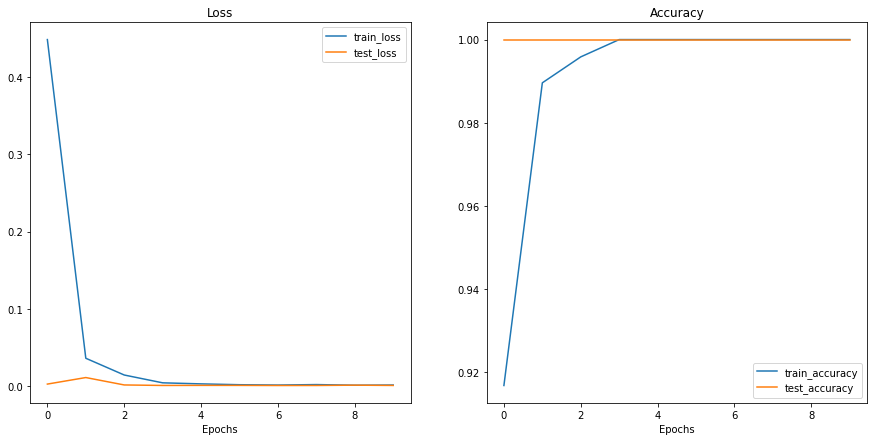

In [37]:
plot_loss_curves(pretrained_vit_swag_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-22k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

#### **ImageNet-22k pretraining**

A much larger dataset for training compared to the standard ImageNet-1K training data. ImageNet-22k is a superset of ImageNet-1k containing millions more images of roughly 22,000 classes instead of ImageNet-1k 1000 classes.

More data, means less overfitting of models and better generalization on unseen data.

**Learning Rate Warm-up**

The learning rate starts small at the beginning of learning and gradually increases until it reaches the desired base learning rate over a set number of epochs. 

Weight updates at the beginning of learning are smaller than those updates towards the end of training to avoid overfitting on early training examples. In normal training, these early raining examples would have primacy effects on potential solutions and heavily influence the direction of learning compared with later training examples. 

**Learning Rate Decay**

The base learning rate used in gradient descent slowly decreases over time. This means smaller weight updates are applied during learning as the model converges closer and closer to an improved solution which is more likely to be optimal. 

**Gradient Clipping**

Stop updating the value of gradients once they exceeded an upper or lower value. Used to prevent vanishing (values very close to zero) or exploding gradients (values much greater than 1).

Prevents very large or tiny updates to the weights which can lead to sub-optimal minimas or none existent learning.